<a href="https://colab.research.google.com/github/laksh22/Blinkception/blob/master/1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1-A: Classification

The aim of this project is to design a neural network which can take in 21 input attributes from cardiotocography studies of foetal heart rate (FHR) and uterine contraction (UC) and output one of 3 labels based on this data: N(normal), S(suspect), P(pathological).

We construct a neural network and experiment with the following hyperparameters to get the fastest yet most accurate model:
- Batch size
- Hidden neurons
- Optimal decay parameter
- Number of hidden layers (3 layer network vs. 4 layer network)

## Setup

We will first import the relevant dependencies and load the data for training and testing

### Loading dependencies

__Tensorflow__ - Constructing the neural networks using the Keras API (Tensorflow 2 is used)  
__Scikit-learn__ - Helper functions such as train-test split and cross-validation  
__Numpy__ - Data manipulation  
__Matplotlib__ - Plotting accuracy and time graphs  

In [ ]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)
tf.random.set_seed(10)

### Setting up the data

1. We first load the data from the csv file, remove the first row which has _nan_, and set the 21 input columns as `X` and the output column as `y`
2. We then use the train_test_split function from sklearn to divide the data into a 70:30 ratio for training and testing
3. We scale the input values using min-max scaling. This ensures all input values are between 0 and 1, which is beneficial for neural networks since large value ranges can lead to erratic gradient descent which requires more time to converge. With normalized data, we can use a larger learning rate without compromising on time needed for convergence
4. Lastly, we convert the `y` values to 0,1,2 to enable easier indexing

In [ ]:
# Loading the data
data = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
data = data[1:] # Remove nan row
X, y = data[1:, :21], data[1:,-1].astype(int)

print(f"There are {len(X)} data points")

There are 2125 data points


In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

print(f"There are {len(X_train)} rows for training ({100*len(X_train)/len(X)} percent)")
print(f"There are {len(X_test)} rows for testing ({100*len(X_test)/len(X)} percent)")

There are 1487 rows for training (69.97647058823529 percent)
There are 638 rows for testing (30.023529411764706 percent)


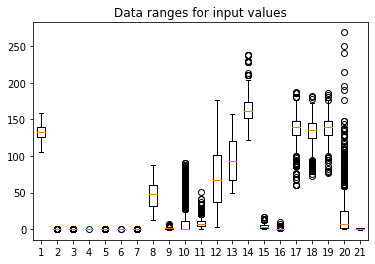

In [ ]:
fig1, data_range = plt.subplots()
data_range.set_title('Data ranges for input values')
data_range.boxplot(X_train);

As we can see the input values can vary a lot and hence require normalization

In [ ]:
# Scaling the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"For training data: min={np.min(X_train)}, max={np.max(X_train)}")
print(f"For testing data: min={np.min(X_test)}, max={np.max(X_test)}")

For training data: min=0.0, max=1.0000000000000002
For testing data: min=0.0, max=1.125


In [ ]:
# Convert to 0,1,2
y_train = y_train-1
y_test = y_test-1

### Creating the K-folds cross validation function

We use 5-fold cross validation in order to find the best model out of 5 after training. The data is split up into 5 sections and 5 different models are trained, each using one of the 5 data splits for validation and using the other 4 for training. This way, data is validated multiple times and ensures that the validation and training set are not biased in any way.

We use `StratifiedKFold` from sklearn to ensure that each fold contains equal instances of each output class.

In [ ]:
# 5-fold cross-validation function
FOLD_COUNT = 5

def get_best_model(model, batch_size, epochs, use_test_data=False, callbacks=[]):
    kf = StratifiedKFold(FOLD_COUNT, shuffle=True, random_state=42)
    
    fold = 0
    
    best_history = None
    best_model = None
    max_accuracy = 0.0;
    
    for train, test in kf.split(X_train, y_train):
        fold += 1
        print(f"Fold #{fold}:", end=" ")
        
        # Setting the hyperparameters
        LEARNING_RATE = 0.01
        OPTIMIZER = SGD(learning_rate=LEARNING_RATE)
        LOSS_TYPE = SparseCategoricalCrossentropy(from_logits=True)
        METRICS = ["accuracy"]
        
        # Splitting the data
        fold_X_train = X_train[train]
        fold_y_train = y_train[train]
        fold_X_test = X_train[test]
        fold_y_test = y_train[test]
        
        # Copy the model
        fold_model = tf.keras.models.clone_model(model)
        
        # Training the model
        fold_model.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
        if use_test_data:
            history = fold_model.fit(fold_X_train, 
                                fold_y_train, 
                                validation_data=(X_test, y_test),
                                batch_size=batch_size, 
                                epochs=epochs, 
                                verbose=0, 
                                callbacks=callbacks)
        else:
            history = fold_model.fit(fold_X_train, 
                                fold_y_train, 
                                validation_data=(fold_X_test, fold_y_test),
                                batch_size=batch_size, 
                                epochs=epochs, 
                                verbose=0, 
                                callbacks=callbacks)
        
        # Predicting on the validation set
        fold_y_test_prediction = fold_model.predict(fold_X_test)
        fold_y_test_prediction = np.argmax(fold_y_test_prediction, axis=1)

        # Measure this fold's accuracy
        accuracy = accuracy_score(fold_y_test, fold_y_test_prediction)
        print(f"Score (accuracy): {accuracy}")

        if(accuracy > max_accuracy):
            max_accuracy = accuracy
            best_model = fold_model
            best_history = history
            
    return best_model, best_history

## Experiments



### 1. Creating the initial Neural Network

We design a feedforward neural network which consists of an __input layer__, __1 hidden layer of 10 neurons (ReLU activation function)__, and an __output softmax layer__. 

- Learning rate alpha = 0.01
- L2 regularization (Weight decay beta - 10<sup>-6</sup>) 
- Batch size - 32

We have already used min-max scaling for the input features

In [ ]:
# Defining the model
model_1 = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])

In [ ]:
# Training the model
epochs_1 = 7000
batch_size_1 = 32
best_model_1, best_history_1 = get_best_model(model_1, batch_size_1, epochs_1, True)

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.8821548821548821
Fold #4: Score (accuracy): 0.8249158249158249
Fold #5: Score (accuracy): 0.8552188552188552


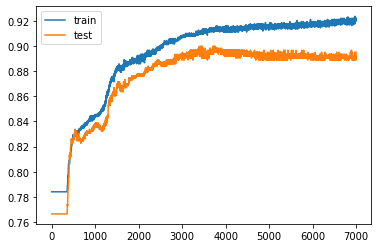

In [ ]:
# Plotting train and test set accuracies vs. epoch
plt.plot(best_history_1.history["accuracy"], label="train")
plt.plot(best_history_1.history["val_accuracy"], label="test")
plt.legend()
plt.show()

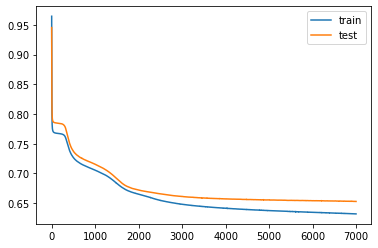

In [ ]:
# Plotting train and test set loss vs. epoch
plt.plot(best_history_1.history["loss"], label="train")
plt.plot(best_history_1.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
# Printing the test losses vs. 1000 epochs
for epoch in range(0, 7000, 1000):
  print(f"Epoch #{epoch} test loss : {best_history_1.history['val_loss'][epoch]}")
print(f"Epoch #7000 test loss : {best_history_1.history['val_loss'][6999]}")

Epoch #0 test loss : 0.9455411434173584
Epoch #1000 test loss : 0.7155147790908813
Epoch #2000 test loss : 0.6720488667488098
Epoch #3000 test loss : 0.6613844633102417
Epoch #4000 test loss : 0.6571815013885498
Epoch #5000 test loss : 0.6554365754127502
Epoch #6000 test loss : 0.6541601419448853
Epoch #7000 test loss : 0.652961254119873


**Conclusion:** We see the following decreases in losses:  

| Epoch | Loss   | Change |
|-------|--------|--------|
| 0     | 0.9455 | -      |
| 1000  | 0.7155 | 0.2300 |
| 2000  | 0.6720 | 0.0435 |
| 3000  | 0.6613 | 0.0107 |
| 4000  | 0.6571 | 0.0042 |
| 5000  | 0.6554 | 0.0017 |
| 6000  | 0.6541 | 0.0013 |
| 7000  | 0.6529 | 0.0012 |

We can see that the loss has a sharp decline till the 3000th epoch after which the change is loss is miniscule as compared to the training time needed. This is also supported by the accuracy graph where the test accuracy increases gradually till the 3000th epoch and then plateaus, increasing only slightly.

In [ ]:
EPOCHS = 3000

### 2. Finding the optimal batch size

Batch size refers to the number of data points fed into the neural network before its weights are updated. Once all the batches representing the data have been fed into the neural network, this consists of an epoch. 

We will explore the effect of batch size on accuracy and training time using the following batch sizes:  
__Search Space__ - [4,8,16,32,64]

In [ ]:
# Define the search space
batch_sizes = [4,8,16,32,64]

In [ ]:
# Define a callback function to store time taken to train
time_taken = []
class TimeCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start = time.clock()
        self.epochs = 0
    def on_epoch_end(self,epoch,logs = {}):
        if(self.epochs is 0):
            time_taken.append(time.clock() - self.start)
            self.epochs = 1

In [ ]:
# Define and train the model
model_2 = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])

batch_size_accuracy = {}

epochs_2 = 600
for batch_size in batch_sizes:
    model_2_copy = tf.keras.models.clone_model(model_2)
    best_model_2, best_history_2 = get_best_model(model_2_copy, batch_size, epochs_2, callbacks=[TimeCallback()])
    
    batch_size_accuracy[batch_size] = best_history_2.history["val_accuracy"]

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946

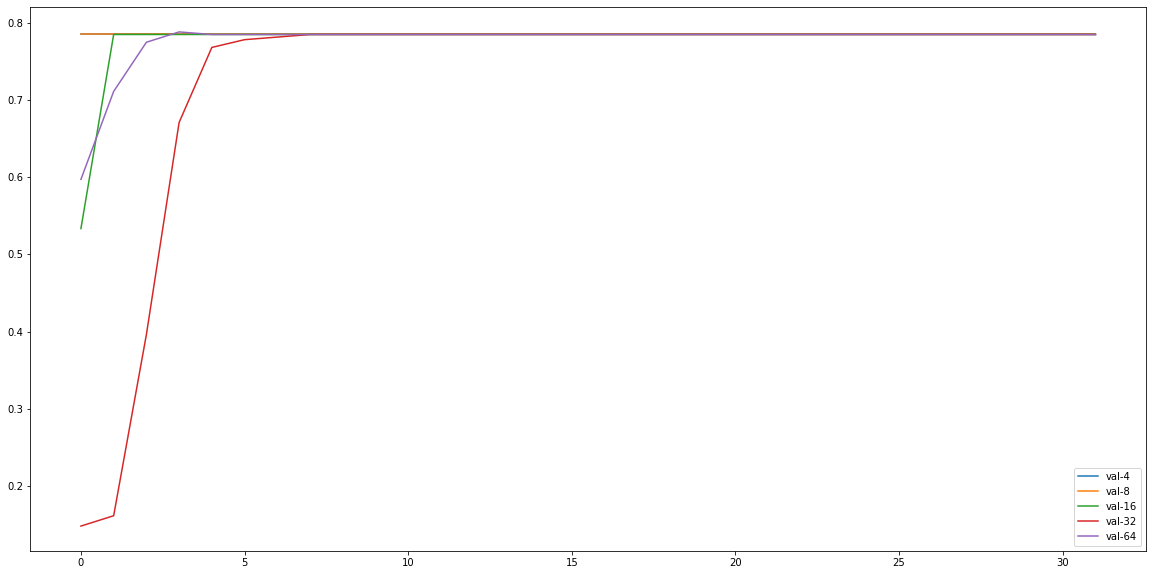

In [ ]:
# Plotting validation accuracies vs. epoch for each batch size

plt.figure(figsize=(20,10))
for batch_size, accuracy in batch_size_accuracy.items():
    plt.plot(accuracy, label=f"val-{batch_size}")

plt.legend()
plt.show()

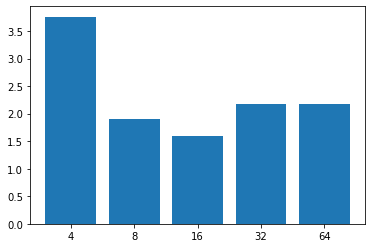

In [ ]:
# Plotting the training time for each batch size
time_per_epoch = {
    4: time_taken[0],
    8: time_taken[1],
    16: time_taken[2],
    32: time_taken[3],
    64: time_taken[4],
}

plt.bar(range(len(time_per_epoch)), list(time_per_epoch.values()), align='center')
plt.xticks(range(len(time_per_epoch)), list(time_per_epoch.keys()))

plt.show()

__Conclusion:__ We see that as the batch size increases, the training time decreases but it also generally takes longer to converge to an optimal value. 

- Larger batch sizes are faster due to lesser overhead of loading a few large batches as opposed to many small batches
- Larger batch sizes converge slower because they converge to sharp minimizers [[1]](https://arxiv.org/pdf/1609.04836.pdf) which vary sharply and it is harder to escape sharp local minima. 

As we can see, batch size of 64 takes the least amount of time to train and converges fairly quickly. We shall continue with a __batch size of 64__.

In [ ]:
BATCH_SIZE = 64

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845


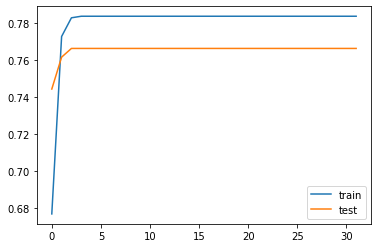

In [ ]:
# Training on optimal batch size and showing train and test accuracy
model_2_copy = tf.keras.models.clone_model(model_2)
best_model_2, best_history_2 = get_best_model(model_2_copy, BATCH_SIZE, epochs_2, True)
    
plt.plot(best_history_2.history["accuracy"], label="train")
plt.plot(best_history_2.history["val_accuracy"], label="test")
plt.legend()
plt.show()

### 3. Finding the optimial number of neurons

Neural networks are composed of layers and each layer has a certain number of "neurons". These neurons pass messages between each layer and help approximate functions.

We will explore the effect of number of neurons on accuracy using the following number of hidden layer neurons:  
__Search Space__ - [5,10,15,20,25]

In [ ]:
# Define the search space
model_sizes = [5,10,15,20,25]

In [ ]:
# Define and train the model
neurons_accuracy = {}

epochs_3 = 15
for model_size in model_sizes:
    model_3 = Sequential([
            Dense(units=model_size, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])
    best_model_3, best_history_3 = get_best_model(model_3, BATCH_SIZE, epochs_3, callbacks=[])
    
    neurons_accuracy[model_size] = best_history_3.history["val_accuracy"]

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946

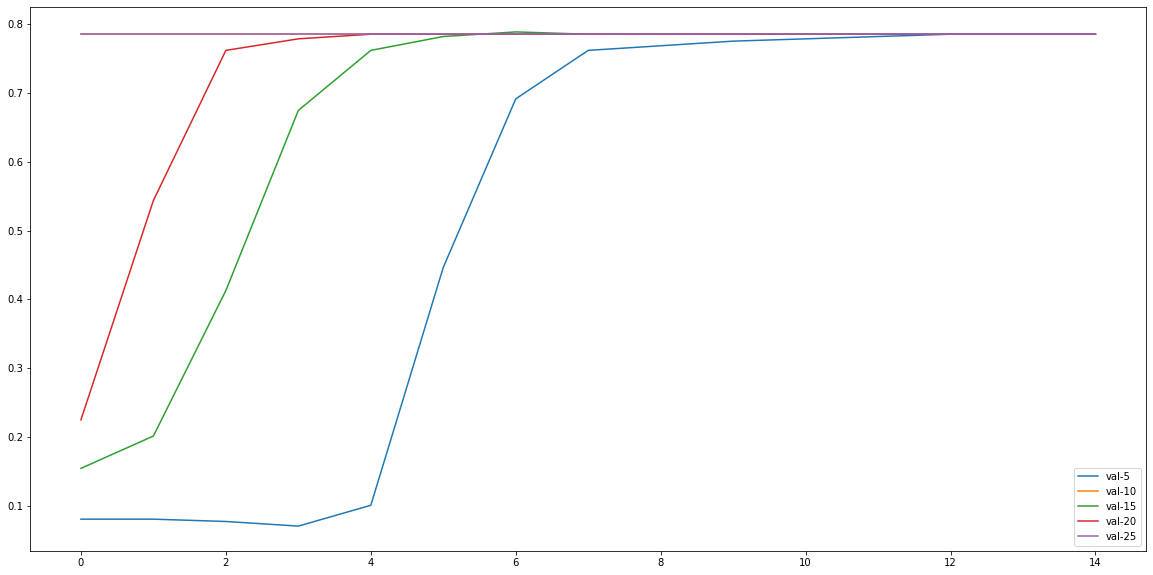

In [ ]:
# Plotting validation accuracies for each batch size
plt.figure(figsize=(20,10))
for model_size, accuracy in neurons_accuracy.items():
    plt.plot(accuracy, label=f"val-{model_size}")

plt.legend()
plt.show()

__Conclusion:__ We can see that as neuron count increases, the time to converge decreases. This is because more neurons are able to learn more complex functions faster. Since the 25 neuron model converges the fastest, we will continue with __25 neurons__.

In [ ]:
NEURON_COUNT = 25

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845


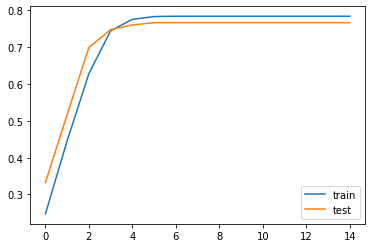

In [ ]:
# Training on optimal neuron count and showing train and test accuracy
model_3 = Sequential([
            Dense(units=NEURON_COUNT, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])
best_model_3, best_history_3 = get_best_model(model_3, BATCH_SIZE, epochs_3, True)
    
plt.plot(best_history_3.history["accuracy"], label="train")
plt.plot(best_history_3.history["val_accuracy"], label="test")
plt.legend()
plt.show()

### 4. Finding the optimal decay parameter

Regularization is a technique used to stop overfitting of data. The regularization term is the sum of squares of the feature weights. When added to the cost, this stops the feature weights from exploding since larger weights mean larger cost. The decay parameter decides how much the regularization term affects the cost.

![L2 regularization](https://www.oreilly.com/library/view/hands-on-machine-learning/9781788393485/assets/320843d0-3683-4422-80b2-c2913f8d02d4.png)

We will explore the effect of decay parameter on accuracy using the following decay parameters:  
__Search space__ - [0, 10<sup>-3</sup>, 10<sup>-6</sup>, 10<sup>-9</sup>, 10<sup>-12</sup>]

In [ ]:
#Define the search space
decay_vals = [0,10**(-3),10**(-6),10**(-9),10**(-12)]

In [ ]:
# Define and train the model
decay_accuracy = {}

epochs_4 = 15
for decay in decay_vals:
    model_4 = Sequential([
            Dense(units=NEURON_COUNT, activation="relu", kernel_regularizer=l2(decay)),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(decay))
        ])
    best_model_4, best_history_4 = get_best_model(model_4, BATCH_SIZE, epochs_4)
    
    decay_accuracy[decay] = best_history_4.history["val_accuracy"]

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845
Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946

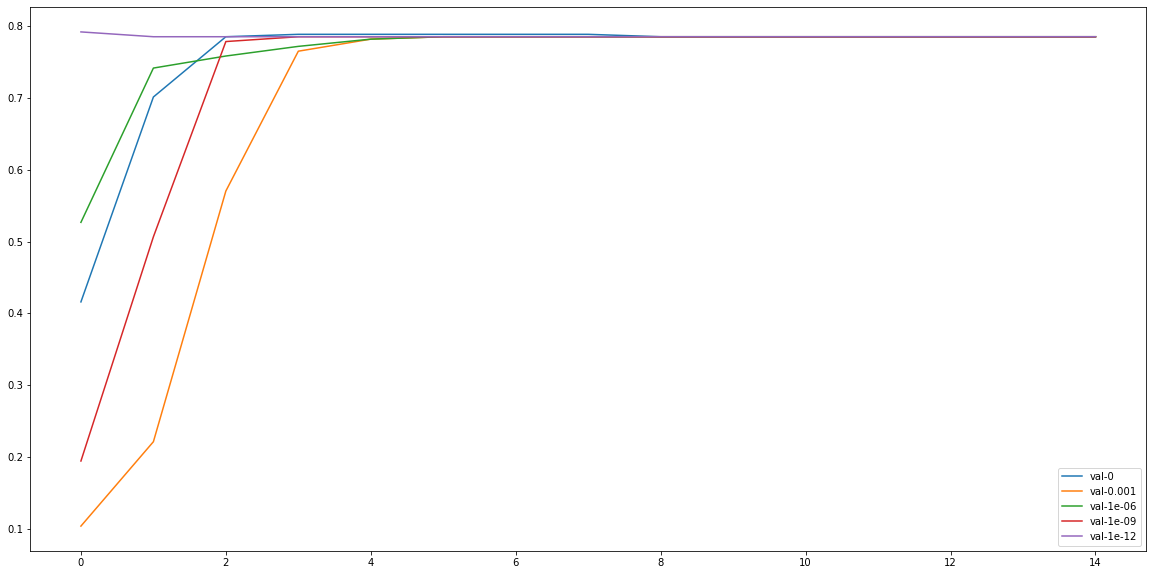

In [ ]:
# Plotting validation accuracies for each decay value
plt.figure(figsize=(20,10))
for decay_val, accuracy in decay_accuracy.items():
    plt.plot(accuracy, label=f"val-{decay_val}")

plt.legend()
plt.show()

__Conclusion:__ We see that as the decay parameter decrases, the model takes longer to converge. This is because the weights update erratically during each batch and take longer to converge to the ideal value. Since the 10<sup>-6</sup> decay model converges fairly fast but also avoids overfitting, we shall continue with a __decay parameter of 10<sup>-6</sup>__.

In [ ]:
DECAY = 10**(-6)

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845


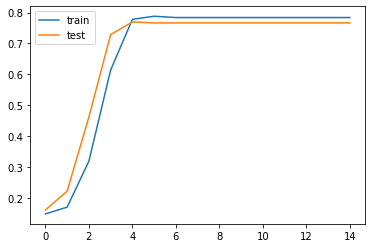

In [ ]:
# Training on optimal decay parameter and showing train and test accuracy
model_4 = Sequential([
            Dense(units=NEURON_COUNT, activation="relu", kernel_regularizer=l2(DECAY)),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(DECAY))
        ])
best_model_4, best_history_4 = get_best_model(model_4, BATCH_SIZE, epochs_4, True)

plt.plot(best_history_4.history["accuracy"], label="train")
plt.plot(best_history_4.history["val_accuracy"], label="test")
plt.legend()
plt.show()

## 5. Training a 4-layer neural network

Adding more layers to a neural network introduces more neurons which can compute more complex functions.

We will explore the effect of layer count on accuracy by comparing the previous 3 layer model and a new 4 layer model with the following hyperparameters:

- 10 neurons in each hidden layer
- Batch size of 32
- Decay parameter of 10<sup>-6</sup>

In [ ]:
# Define and train the model
epochs_5 = 15
model_5 = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])
best_model_5, best_history_5 = get_best_model(model_5, 32, epochs_5)

Fold #1: Score (accuracy): 0.785234899328859
Fold #2: Score (accuracy): 0.7818791946308725
Fold #3: Score (accuracy): 0.7845117845117845
Fold #4: Score (accuracy): 0.7845117845117845
Fold #5: Score (accuracy): 0.7845117845117845


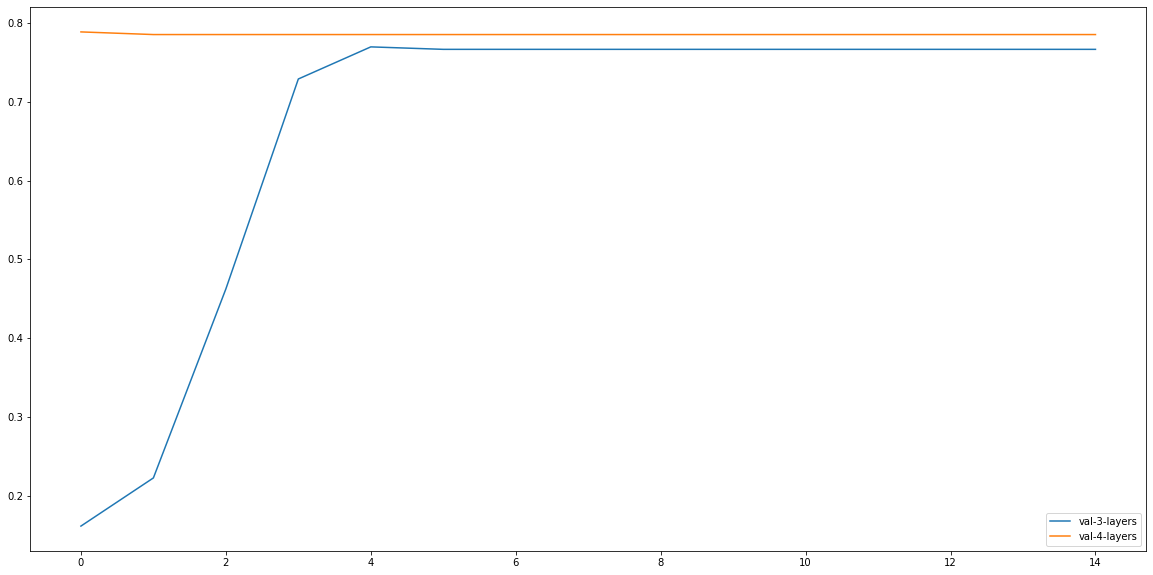

In [ ]:
# Plotting validation accuracies for 3-layer and 4-layer network
plt.figure(figsize=(20,10))
plt.plot(best_history_4.history["val_accuracy"], label=f"val-{3}-layers")
plt.plot(best_history_5.history["val_accuracy"], label=f"val-{4}-layers")
    
plt.legend()
plt.show()

__Conclusion:__ We see that the 4-layer network with 10 neurons in the hidden layers each generally performs better than the 3 layer network. This is because the 4-layer network has more neurons which can learn more complex functions from the input dataset